# Determining Data Science Union Status

### Dustin Berry

***

**This project will outline the steps taken to determine whether or not a member of the United Data Scientists Union (UDSU) will continue their membership based on data science practices.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
#read in the data
train = pd.read_csv('Dustin-TRAIN.csv', sep=',')

train.head()

,ID,gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,FeatureA,Connectivity,FeatureC,...,FeatureE,FeatureF,FeatureG,FeatureB,DuesFrequency,PaperlessBilling,PaymentMethod,MonthlyDues,TotalDues,LeftUnion
0,Dustin 1-15331,Female,0,Yes,No,20,Yes,No,other,Maryville,...,Maryville,Maryville,Maryville,Maryville,Month-to-month,No,Bank transfer (automatic),19,375,No
1,Dustin 2-17543,Female,0,No,No,5,Yes,No,Fiber optic,No,...,No,Yes,No,Yes,Month-to-month,Yes,Electronic check,89,462,Yes
2,Dustin 3-15779,Female,0,No,No,48,Yes,No,Fiber optic,No,...,No,No,No,No,One year,No,Electronic check,75,3773,No
3,Dustin 4-15518,Female,0,Yes,No,1,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,69,69,Yes
4,Dustin 5-15775,Male,0,No,No,3,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,70,220,No


## Exploratory Data Analysis (EDA)

In [3]:
#total number of rows and columns
print('Number of rows and columns: ', train.shape)

#rows containing duplicate data
duplicate_rows_df = train[train.duplicated()]
print('Number of duplicate rows:   ', duplicate_rows_df.shape)

Number of rows and columns:  (999, 21)
Number of duplicate rows:    (0, 21)


This tells us that there are 999 observations (rows) and 21 variables (columns).  One of the variables will be the target that we will use to train the model.  In this project we will not need the ID variable, so I will remove it now.

In [4]:
#remove ID column before as it is irrelevant to the computation
train = train.drop(['ID'],axis=1)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            999 non-null    object
 1   Management        999 non-null    int64 
 2   USAcitizen        999 non-null    object
 3   Married           999 non-null    object
 4   MonthsInUnion     999 non-null    int64 
 5   ContinuingEd      999 non-null    object
 6   FeatureA          999 non-null    object
 7   Connectivity      999 non-null    object
 8   FeatureC          999 non-null    object
 9   FeatureD          999 non-null    object
 10  FeatureE          999 non-null    object
 11  FeatureF          999 non-null    object
 12  FeatureG          999 non-null    object
 13  FeatureB          999 non-null    object
 14  DuesFrequency     999 non-null    object
 15  PaperlessBilling  999 non-null    object
 16  PaymentMethod     999 non-null    object
 17  MonthlyDues     

The dataframe is primarily made up of categorical variables (object) with three variables that are integers (int64).  Additionally, there are no null or missing values in the data.  What is interesting is the TotalDues variable is listed as an object, but should be an int64.  There is likely a text value in at least one cell of that column that we'll have to fix.

If we were to run the code below it would give an error as it's not possible to convert the string to numeric without further manipulation.

In [6]:
#this error tells us that the string '#VALUE!' is in the TotalDues column at the 925th position
#train['TotalDues'] = pd.to_numeric(train['TotalDues'])

In [7]:
#there it is
print(train.loc[925])

gender                    Female
Management                     0
USAcitizen                   Yes
Married                      Yes
MonthsInUnion                  0
ContinuingEd                 Yes
FeatureA                      No
Connectivity                 DSL
FeatureC                     Yes
FeatureD                     Yes
FeatureE                     Yes
FeatureF                      No
FeatureG                     Yes
FeatureB                     Yes
DuesFrequency           Two year
PaperlessBilling              No
PaymentMethod       Mailed check
MonthlyDues                   81
TotalDues                #VALUE!
LeftUnion                     No
Name: 925, dtype: object


In [8]:
#now to replace it with NaN and transform the column to numeric
train.replace('#VALUE!', np.nan, inplace=True)
train['TotalDues'] = pd.to_numeric(train['TotalDues'])

#impute NaN with mean of the column
train2 = train.fillna(train.mean().round(0))

print(train.TotalDues.dtypes)
print(train2.TotalDues[925])

float64
2229.0


In [9]:
train.describe()

,Management,MonthsInUnion,MonthlyDues,TotalDues
count,999.000000,999.000000,999.000000,998.000000
mean,0.157157,34.031031,81.266266,2229.321643
std,0.364131,40.201622,377.980828,2218.813802
min,0.000000,0.000000,19.000000,19.000000
25%,0.000000,9.000000,34.500000,417.500000
50%,0.000000,29.000000,70.000000,1353.500000
75%,0.000000,55.000000,90.000000,3680.000000
max,1.000000,672.000000,11268.000000,8685.000000


Here we see the numerical variables and their corresponding summary statistics.  Based on the difference between the mean and median, and the 75th percentile and max there is likely outliers in the data that will need to be removed.

Next we will use box and whisker plots to see the outlying data points in the numerical data.  The data points outside of the whisker lines represent the outlying information.  Additionally, by understanding that the Management variable is actually a boolean value rather than an integer it isn't necessary to plot. 

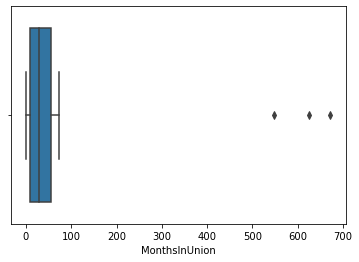

In [10]:
sns.boxplot(x=train['MonthsInUnion'])

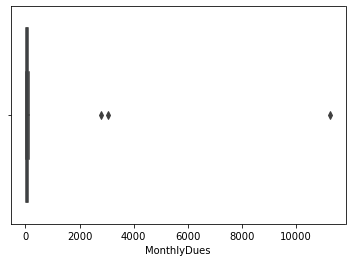

In [11]:
sns.boxplot(x=train['MonthlyDues'])

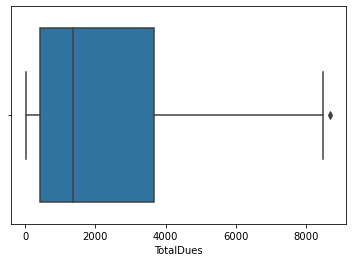

In [12]:
sns.boxplot(x=train['TotalDues'])

Now we can remove the outliers that fall outside of the middle 50% of the data (interquartile range).

In [13]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1

train3 = train2[~((train2 < (Q1 - 1.5 * IQR))|(train2 > (Q3 + 1.5 * IQR))).any(axis=1)]
train3.shape

(838, 20)

We are left with 838 rows.

In [14]:
train3.LeftUnion.value_counts()

No     654
Yes    184
Name: LeftUnion, dtype: int64

Here we see that of the 838 observations, 654 did not leave the union.  This is 78.04% and will serve as the basis for our prediction accuracy.

The scatter plots below show that there is likely no direct impact to union status of either months in union or monthly dues as standalone features once the outliers are removed.

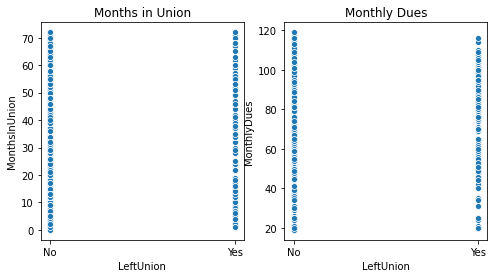

In [15]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

ax1.set_title('Months in Union')
sns.scatterplot(x='LeftUnion', y='MonthsInUnion', data=train3, ax=ax1)

ax2.set_title('Monthly Dues')
sns.scatterplot(x='LeftUnion', y='MonthlyDues', data=train3, ax=ax2)

Here I will display scatter plots that show the relationships of the variables.

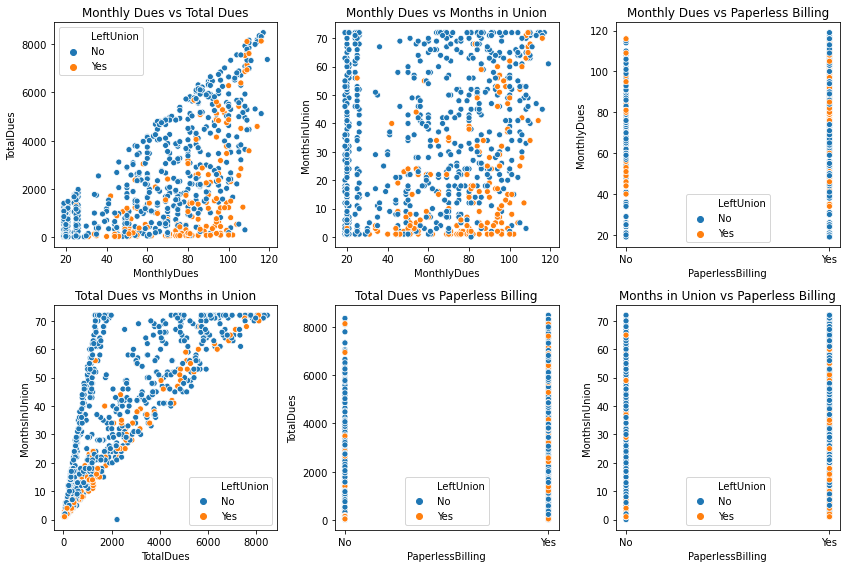

In [16]:
fig=plt.figure(figsize=(12,8))

plt.subplot(2,3,1)
plt.title('Monthly Dues vs Total Dues')
sns.scatterplot(x='MonthlyDues', y='TotalDues', data=train3, hue='LeftUnion')

plt.subplot(2,3,2)
plt.title('Monthly Dues vs Months in Union')
sns.scatterplot(x='MonthlyDues', y='MonthsInUnion', data=train3, hue='LeftUnion', legend=False)

plt.subplot(2,3,3)
plt.title('Monthly Dues vs Paperless Billing')
sns.scatterplot(x='PaperlessBilling', y='MonthlyDues', data=train3, hue='LeftUnion')

plt.subplot(2,3,4)
plt.title('Total Dues vs Months in Union')
sns.scatterplot(x='TotalDues', y='MonthsInUnion', data=train3, hue='LeftUnion')

plt.subplot(2,3,5)
plt.title('Total Dues vs Paperless Billing')
sns.scatterplot(x='PaperlessBilling', y='TotalDues', data=train3, hue='LeftUnion')

plt.subplot(2,3,6)
plt.title('Months in Union vs Paperless Billing')
sns.scatterplot(x='PaperlessBilling', y='MonthsInUnion', data=train3, hue='LeftUnion')

plt.tight_layout()
plt.show()

Let's take a closer look at the charts with paperless billing.

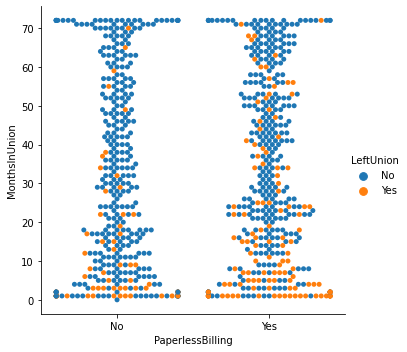

In [17]:
sns.catplot(x='PaperlessBilling', y='MonthsInUnion', data=train3, hue='LeftUnion', kind='swarm')
plt.show()

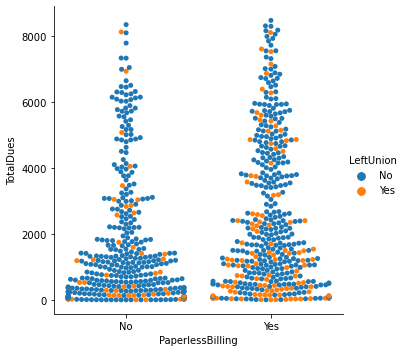

In [18]:
sns.catplot(x='PaperlessBilling', y='TotalDues', data=train3, hue='LeftUnion', kind='swarm')
plt.show()

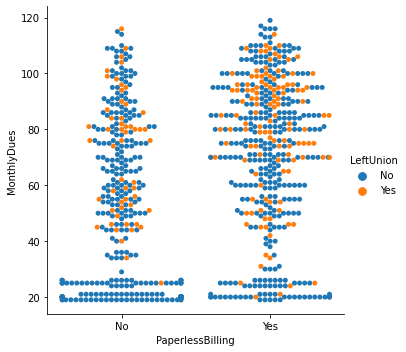

In [19]:
sns.catplot(x='PaperlessBilling', y='MonthlyDues', data=train3, hue='LeftUnion', kind='swarm')

Finally we'll see plots of other categorical variables as they relate to leaving the union.

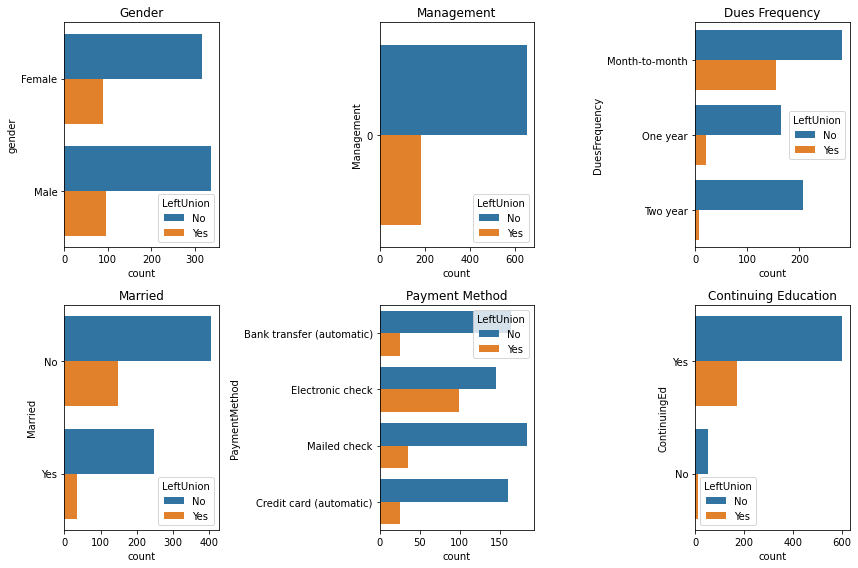

In [20]:
fig=plt.figure(figsize=(12,8))

plt.subplot(2,3,1)
plt.title('Gender')
sns.countplot(y ='gender', hue = 'LeftUnion', data = train3)

plt.subplot(2,3,2)
plt.title('Management')
sns.countplot(y ='Management', hue = 'LeftUnion', data = train3)

plt.subplot(2,3,3)
plt.title('Dues Frequency')
sns.countplot(y ='DuesFrequency', hue = 'LeftUnion', data = train3)

plt.subplot(2,3,4)
plt.title('Married')
sns.countplot(y ='Married', hue = 'LeftUnion', data = train3)

plt.subplot(2,3,5)
plt.title('Payment Method')
sns.countplot(y ='PaymentMethod', hue = 'LeftUnion', data = train3)

plt.subplot(2,3,6)
plt.title('Continuing Education')
sns.countplot(y ='ContinuingEd', hue = 'LeftUnion', data = train3)

plt.tight_layout()
plt.show()

**Next we will split the numerical features from the categorical features for one-hot encoding and standardization.**

In [21]:
train_num = train3[['MonthsInUnion','MonthlyDues','TotalDues']]
train_cat = train3[['Management','gender', 'USAcitizen', 'Married','ContinuingEd', 'FeatureA', 'Connectivity', 'FeatureC', 
                             'FeatureD','FeatureE', 'FeatureF', 'FeatureG', 'FeatureB', 'DuesFrequency','PaperlessBilling',
                             'PaymentMethod']]
y1 = train3[['LeftUnion']]

print("Numerical FeatureShape:      "+ str(train_num.shape))
print("Categorical Feature Shape:   "+ str(train_cat.shape))
print("Target Shape:                "+ str(y1.shape))

Numerical FeatureShape:      (838, 3)
Categorical Feature Shape:   (838, 16)
Target Shape:                (838, 1)


In [22]:
train_cat.head()

,Management,gender,USAcitizen,Married,ContinuingEd,FeatureA,Connectivity,FeatureC,FeatureD,FeatureE,FeatureF,FeatureG,FeatureB,DuesFrequency,PaperlessBilling,PaymentMethod
0,0,Female,Yes,No,Yes,No,other,Maryville,Maryville,Maryville,Maryville,Maryville,Maryville,Month-to-month,No,Bank transfer (automatic)
1,0,Female,No,No,Yes,No,Fiber optic,No,Yes,No,Yes,No,Yes,Month-to-month,Yes,Electronic check
2,0,Female,No,No,Yes,No,Fiber optic,No,Yes,No,No,No,No,One year,No,Electronic check
3,0,Female,Yes,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check
4,0,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check


In [23]:
#one-hot encoding of categorical variables in order to give them numerical values
train_enc = pd.get_dummies(train_cat)
train_enc.head()

,Management,gender_Female,gender_Male,USAcitizen_No,USAcitizen_Yes,Married_No,Married_Yes,ContinuingEd_No,ContinuingEd_Yes,FeatureA_Maryville,...,FeatureB_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,0,1,1,0,0,1,0,...,0,1,0,0,1,0,1,0,0,0
1,0,1,0,1,0,1,0,0,1,0,...,1,1,0,0,0,1,0,0,1,0
2,0,1,0,1,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0
3,0,1,0,0,1,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4,0,0,1,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1


In [24]:
#standardizing numerical values to keep larger numbers from skewing the model results
train_num2 = StandardScaler().fit_transform(train_num)

print("Encoded Feature Array Shape: " + str(train_num.shape))

#check mean and standard deviation
print(np.mean(train_num2),np.std(train_num2))

Encoded Feature Array Shape: (838, 3)
-1.9784403939223156e-17 0.9999999999999999


In [25]:
#reset into dataframe
train_num3 = pd.DataFrame(train_num2)
train_num3

,0,1,2
0,-0.495038,-1.414696,-0.809597
1,-1.112607,0.903092,-0.769343
2,0.657758,0.439534,0.762638
3,-1.277292,0.240867,-0.951181
4,-1.194950,0.273978,-0.881315
...,...,...,...
833,-1.153779,-0.355136,-0.913240
834,1.440012,0.903092,1.748177
835,-0.000983,0.108422,-0.052629
836,-1.236121,-1.216029,-0.954420


In [26]:
#combine the numerical and categrical datasets
norm_train = pd.DataFrame(np.hstack([train_num3, train_enc]))

print("Feature Shape: " + str(norm_train.shape))

Feature Shape: (838, 46)


In [27]:
norm_train.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-0.495038,-1.414696,-0.809597,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-1.112607,0.903092,-0.769343,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.657758,0.439534,0.762638,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.277292,0.240867,-0.951181,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.194950,0.273978,-0.881315,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Some of the column labels didn't transfer over.  I'll add them in manually.

In [28]:
norm_train = norm_train.rename(columns = {norm_train.columns[0]:'MonthsInUnion',
                                 norm_train.columns[1]:'MonthlyDues',
                                 norm_train.columns[2]:'TotalDues', 
                                 norm_train.columns[3]:'Management',
                                 norm_train.columns[4]:'gender_Female',
                                 norm_train.columns[5]:'gender_Male', 
                                 norm_train.columns[6]:'USAcitizen_No',
                                 norm_train.columns[7]:'USAcitizen_Yes',
                                 norm_train.columns[8]:'Married_No', 
                                 norm_train.columns[9]:'Married_Yes',
                                 norm_train.columns[10]:'ContinuingEd_No',
                                 norm_train.columns[11]:'ContinuingEd_Yes', 
                                 norm_train.columns[12]:'FeatureA_Maryville',
                                 norm_train.columns[13]:'FeatureA_No',
                                 norm_train.columns[14]:'FeatureA_Yes', 
                                 norm_train.columns[15]:'Connectivity_DSL',
                                 norm_train.columns[16]:'Connectivity_Dial-in',
                                 norm_train.columns[17]:'Connectivity_Fiber optic', 
                                 norm_train.columns[18]:'Connectivity_other',
                                 norm_train.columns[19]:'FeatureC_Maryville',
                                 norm_train.columns[20]:'FeatureC_No', 
                                 norm_train.columns[21]:'FeatureC_Yes',
                                 norm_train.columns[22]:'FeatureD_Maryville',
                                 norm_train.columns[23]:'FeatureD_No', 
                                 norm_train.columns[24]:'FeatureD_Yes',
                                 norm_train.columns[25]:'FeatureE_Maryville',
                                 norm_train.columns[26]:'FeatureE_No', 
                                 norm_train.columns[27]:'FeatureE_Yes',
                                 norm_train.columns[28]:'FeatureF_Maryville',
                                 norm_train.columns[29]:'FeatureF_No', 
                                 norm_train.columns[30]:'FeatureF_Yes',
                                 norm_train.columns[31]:'FeatureG_Maryville',
                                 norm_train.columns[32]:'FeatureG_No', 
                                 norm_train.columns[33]:'FeatureG_Yes',
                                 norm_train.columns[34]:'FeatureB_Maryville',
                                 norm_train.columns[35]:'FeatureB_No', 
                                 norm_train.columns[36]:'FeatureB_Yes',
                                 norm_train.columns[37]:'DuesFrequency_Month-to-month',
                                 norm_train.columns[38]:'DuesFrequency_One year', 
                                 norm_train.columns[39]:'DuesFrequency_Two year',
                                 norm_train.columns[40]:'PaperlessBilling_No',
                                 norm_train.columns[41]:'PaperlessBilling_Yes', 
                                 norm_train.columns[42]:'PaymentMethod_Bank transfer (automatic)',
                                 norm_train.columns[43]:'PaymentMethod_Credit card (automatic)',
                                 norm_train.columns[44]:'PaymentMethod_Electronic check', 
                                 norm_train.columns[45]:'PaymentMethod_Mailed check'})

norm_train.head()

,MonthsInUnion,MonthlyDues,TotalDues,Management,gender_Female,gender_Male,USAcitizen_No,USAcitizen_Yes,Married_No,Married_Yes,...,FeatureB_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.495038,-1.414696,-0.809597,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-1.112607,0.903092,-0.769343,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.657758,0.439534,0.762638,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.277292,0.240867,-0.951181,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.194950,0.273978,-0.881315,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Principal Component Analysis (PCA)

In [29]:
pca = PCA(n_components=6)
principalComponents_train = pca.fit_transform(norm_train)

In [30]:
print(principalComponents_train.shape)

(838, 6)


In [31]:
#renaming and passing to a dataframe
principalComponents_train_Df = pd.DataFrame(data = principalComponents_train
             , columns = ['p_c_1', 'p_c_2','p_c_3','p_c_4','p_c_5','p_c_6'])
principalComponents_train_Df.head()

,p_c_1,p_c_2,p_c_3,p_c_4,p_c_5,p_c_6
0,-2.754512,0.909378,-0.332154,0.031355,-0.932701,0.368379
1,0.336463,-1.949707,-0.741232,-0.383069,-0.710969,0.215439
2,0.897883,-0.460625,0.071635,-0.722113,-1.106999,-0.729675
3,-0.432554,-2.209424,0.131321,0.974479,-0.898304,-0.337410
4,-0.490505,-2.492755,-0.375757,0.193169,0.486368,-0.486194


In [32]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.29132378 0.19659788 0.06824455 0.04875409 0.04345813 0.04115184]


In [33]:
#find the sum of the principal components
np.sum(np.array([0.29132378, 0.19659788, 0.06824464, 0.04875361, 0.04345802, 0.0411694]))

0.68954733

Screeplot of the Principal Components

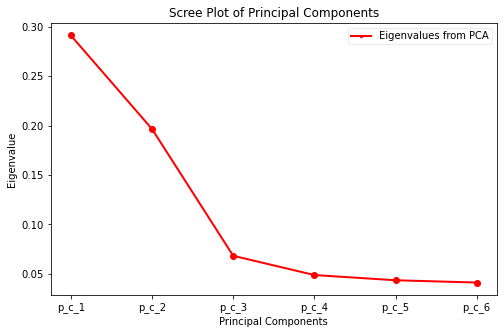

In [34]:
fig = plt.figure(figsize=(8,5))
plt.plot(principalComponents_train_Df.columns, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalue') 
plt.title('Scree Plot of Principal Components')
leg = plt.legend(['Eigenvalues from PCA'], loc='best', borderpad=0.3, 
                 shadow=False,markerscale=0.4)
leg.get_frame().set_alpha(0.4)
plt.show()

The following output shows that there is a high correlation among variables 34, 28, 25, 22, 19, and 31.  We will remove all but one as to not skew the results of the model.

In [35]:
df_comp = pd.DataFrame(pca.components_,index=list(['component 0', 'component 1', 'component 2',
                                                  'component 3','component 4', 'component 5']))
components = df_comp.sort_values(by ='component 0', axis=1,ascending=False).round(decimals=6)

components.transpose()

,component 0,component 1,component 2,component 3,component 4,component 5
1,0.497721,-0.154703,-0.272838,0.052960,-0.069477,0.206322
2,0.451990,0.321064,-0.050546,-0.099254,-0.045541,-0.036587
0,0.265983,0.525071,0.100841,-0.079468,0.027126,-0.347097
36,0.169384,0.014868,-0.127382,-0.056317,0.051965,0.258042
33,0.166382,0.018162,-0.122243,0.019335,0.084836,0.271087
27,0.153096,0.046385,-0.010935,-0.070270,0.038219,0.209641
17,0.146285,-0.100610,-0.302659,0.135827,-0.121277,-0.045905
24,0.136613,0.037654,0.051168,-0.102270,0.009881,-0.003495
30,0.125970,0.047078,0.146535,-0.150726,0.081638,0.138961
21,0.116088,0.033731,0.220388,-0.135721,0.019755,0.160576


In [36]:
#identify the columns
norm_train.iloc[:, [34,28,25,22,19,31]].head()

,FeatureB_Maryville,FeatureF_Maryville,FeatureE_Maryville,FeatureD_Maryville,FeatureC_Maryville,FeatureG_Maryville
0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


The heatmap visualization below shows the correlation to be true.

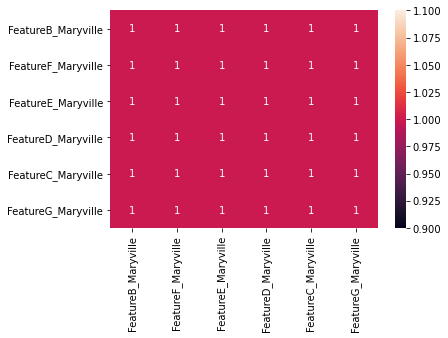

In [37]:
correlation = norm_train.iloc[:, [34,28,25,22,19,31]]
corr = correlation.corr()
sns.heatmap(corr, annot=True)

In [38]:
#removing all but one of the correlated variables
X_train_final = norm_train.drop(['FeatureB_Maryville',
                                      'FeatureF_Maryville',
                                      'FeatureE_Maryville',
                                      'FeatureD_Maryville',
                                      'FeatureC_Maryville'], axis = 1)
X_train_final.head()

,MonthsInUnion,MonthlyDues,TotalDues,Management,gender_Female,gender_Male,USAcitizen_No,USAcitizen_Yes,Married_No,Married_Yes,...,FeatureB_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.495038,-1.414696,-0.809597,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-1.112607,0.903092,-0.769343,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.657758,0.439534,0.762638,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.277292,0.240867,-0.951181,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.194950,0.273978,-0.881315,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Prepare the Test Dataset for Deployment

This section will introduce the same steps as were followed in the training dataset to ensure the features are the same.

In [39]:
test = pd.read_csv('DSCI-508-Competition-Test_Data.csv')
test1 = test.drop(['DS_ID'],axis=1)
test1.head()

,gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,FeatureA,Connectivity,FeatureC,FeatureD,FeatureE,FeatureF,FeatureG,FeatureB,DuesFrequency,PaperlessBilling,PaymentMethod,MonthlyDues,TotalDues
0,Male,0,Yes,No,1,No,Maryville,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,30,30
1,Female,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,57,1890
2,Female,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,54,108
3,Female,0,No,No,45,No,Maryville,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42,1841
4,Male,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,71,152


We can see that there's an issue in the Total Dues column as there was in the training set.

In [40]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            5000 non-null   object
 1   Management        5000 non-null   int64 
 2   USAcitizen        5000 non-null   object
 3   Married           5000 non-null   object
 4   MonthsInUnion     5000 non-null   int64 
 5   ContinuingEd      5000 non-null   object
 6   FeatureA          5000 non-null   object
 7   Connectivity      5000 non-null   object
 8   FeatureC          5000 non-null   object
 9   FeatureD          5000 non-null   object
 10  FeatureE          5000 non-null   object
 11  FeatureF          5000 non-null   object
 12  FeatureG          5000 non-null   object
 13  FeatureB          5000 non-null   object
 14  DuesFrequency     5000 non-null   object
 15  PaperlessBilling  5000 non-null   object
 16  PaymentMethod     5000 non-null   object
 17  MonthlyDues   

In [41]:
#now to replace the string(s) with NaN and transform the column to numeric
test1.replace('#VALUE!', np.nan, inplace=True)
test1['TotalDues'] = pd.to_numeric(test1['TotalDues'])

#impute NaN with mean of the column
test2 = test1.fillna(test1.mean().round(0))

In [42]:
#split the data into numerical and categorical values
test_num = test2[['MonthsInUnion','MonthlyDues','TotalDues']]
test_cat = test2[['Management','gender', 'USAcitizen', 'Married','ContinuingEd', 'FeatureA', 'Connectivity', 'FeatureC', 
                             'FeatureD','FeatureE', 'FeatureF', 'FeatureG', 'FeatureB', 'DuesFrequency','PaperlessBilling',
                             'PaymentMethod']]

print("Numerical Feature  Shape:     "+ str(test_num.shape))
print("Categorical Feature  Shape:   "+ str(test_cat.shape))

Numerical Feature  Shape:     (5000, 3)
Categorical Feature  Shape:   (5000, 16)


In [43]:
#one-hot encoding of categorical variables in order to give them numerical values
test_enc = pd.get_dummies(test_cat)
test_enc.head()

,Management,gender_Female,gender_Male,USAcitizen_No,USAcitizen_Yes,Married_No,Married_Yes,ContinuingEd_No,ContinuingEd_Yes,FeatureA_Maryville,...,FeatureB_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0,1,0,1,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,1,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,1,0,1,0,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,0,1,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [44]:
#standardizing numerical values to keep larger numbers from skewing the model results
test_num2 = StandardScaler().fit_transform(test_num)

print("Encoded Feature Array Shape: " + str(test_num.shape))

#check mean and standard deviation
print(np.mean(test_num2),np.std(test_num2))

Encoded Feature Array Shape: (5000, 3)
6.963318810448982e-17 1.0


In [45]:
#reset into dataframe
test_num3 = pd.DataFrame(test_num2)
test_num3

,0,1,2
0,-1.268931,-1.154574,-0.990430
1,0.070734,-0.258882,-0.169917
2,-1.228335,-0.358403,-0.956021
3,0.517289,-0.756488,-0.191533
4,-1.228335,0.205551,-0.936611
...,...,...,...
4995,-1.025355,0.338247,-0.759716
4996,0.598481,0.305073,0.538547
4997,-1.228335,-0.656967,-0.962197
4998,1.207420,1.532503,2.107668


In [46]:
#combine the numerical and categrical datasets
norm_test = pd.DataFrame(np.hstack([test_num3, test_enc]))

print("Feature Shape: " + str(norm_test.shape))

Feature Shape: (5000, 46)


In [47]:
norm_test.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-1.268931,-1.154574,-0.990430,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.070734,-0.258882,-0.169917,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.228335,-0.358403,-0.956021,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.517289,-0.756488,-0.191533,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-1.228335,0.205551,-0.936611,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [48]:
norm_test = norm_test.rename(columns = {norm_test.columns[0]:'MonthsInUnion',
                                 norm_test.columns[1]:'MonthlyDues',
                                 norm_test.columns[2]:'TotalDues', 
                                 norm_test.columns[3]:'Management',
                                 norm_test.columns[4]:'gender_Female',
                                 norm_test.columns[5]:'gender_Male', 
                                 norm_test.columns[6]:'USAcitizen_No',
                                 norm_test.columns[7]:'USAcitizen_Yes',
                                 norm_test.columns[8]:'Married_No', 
                                 norm_test.columns[9]:'Married_Yes',
                                 norm_test.columns[10]:'ContinuingEd_No',
                                 norm_test.columns[11]:'ContinuingEd_Yes', 
                                 norm_test.columns[12]:'FeatureA_Maryville',
                                 norm_test.columns[13]:'FeatureA_No',
                                 norm_test.columns[14]:'FeatureA_Yes', 
                                 norm_test.columns[15]:'Connectivity_DSL',
                                 norm_test.columns[16]:'Connectivity_Dial-in',
                                 norm_test.columns[17]:'Connectivity_Fiber optic', 
                                 norm_test.columns[18]:'Connectivity_other',
                                 norm_test.columns[19]:'FeatureC_Maryville',
                                 norm_test.columns[20]:'FeatureC_No', 
                                 norm_test.columns[21]:'FeatureC_Yes',
                                 norm_test.columns[22]:'FeatureD_Maryville',
                                 norm_test.columns[23]:'FeatureD_No', 
                                 norm_test.columns[24]:'FeatureD_Yes',
                                 norm_test.columns[25]:'FeatureE_Maryville',
                                 norm_test.columns[26]:'FeatureE_No', 
                                 norm_test.columns[27]:'FeatureE_Yes',
                                 norm_test.columns[28]:'FeatureF_Maryville',
                                 norm_test.columns[29]:'FeatureF_No', 
                                 norm_test.columns[30]:'FeatureF_Yes',
                                 norm_test.columns[31]:'FeatureG_Maryville',
                                 norm_test.columns[32]:'FeatureG_No', 
                                 norm_test.columns[33]:'FeatureG_Yes',
                                 norm_test.columns[34]:'FeatureB_Maryville',
                                 norm_test.columns[35]:'FeatureB_No', 
                                 norm_test.columns[36]:'FeatureB_Yes',
                                 norm_test.columns[37]:'DuesFrequency_Month-to-month',
                                 norm_test.columns[38]:'DuesFrequency_One year', 
                                 norm_test.columns[39]:'DuesFrequency_Two year',
                                 norm_test.columns[40]:'PaperlessBilling_No',
                                 norm_test.columns[41]:'PaperlessBilling_Yes', 
                                 norm_test.columns[42]:'PaymentMethod_Bank transfer (automatic)',
                                 norm_test.columns[43]:'PaymentMethod_Credit card (automatic)',
                                 norm_test.columns[44]:'PaymentMethod_Electronic check', 
                                 norm_test.columns[45]:'PaymentMethod_Mailed check'})

norm_test.head()

,MonthsInUnion,MonthlyDues,TotalDues,Management,gender_Female,gender_Male,USAcitizen_No,USAcitizen_Yes,Married_No,Married_Yes,...,FeatureB_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.268931,-1.154574,-0.990430,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.070734,-0.258882,-0.169917,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.228335,-0.358403,-0.956021,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.517289,-0.756488,-0.191533,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-1.228335,0.205551,-0.936611,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [49]:
#removing all but one of the correlated variables
X_test_final = norm_test.drop(['FeatureB_Maryville',
                                      'FeatureF_Maryville',
                                      'FeatureE_Maryville',
                                      'FeatureD_Maryville',
                                      'FeatureC_Maryville'], axis = 1)
X_test_final.head()

,MonthsInUnion,MonthlyDues,TotalDues,Management,gender_Female,gender_Male,USAcitizen_No,USAcitizen_Yes,Married_No,Married_Yes,...,FeatureB_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.268931,-1.154574,-0.990430,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.070734,-0.258882,-0.169917,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.228335,-0.358403,-0.956021,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.517289,-0.756488,-0.191533,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-1.228335,0.205551,-0.936611,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Running Models and Predictions

Prepare data for modelling.

In [50]:
#convert y1 from string to integer for modelling
d = {'No': 0, 'Yes': 1}
y1['LeftUnion'] = y1['LeftUnion'].map(d).fillna(y1['LeftUnion'])
y1 = np.ravel(y1)

<ipython-input-50-7b9aeeaafb29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y1['LeftUnion'] = y1['LeftUnion'].map(d).fillna(y1['LeftUnion'])


In [51]:
X_train, X_valid, y_train, y_valid =\
    train_test_split(X_train_final, y1, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_valid.shape)

(670, 41)
(168, 41)


**Linear Regression**

As this is a binary classificaltion problem, the linear regression doesn't do very well.  Not only are the r-Squared values extremely low, the predictions are output as decimal values between 1 and 0.  We won't add this into our final dataframe.

In [52]:
linreg_mod = LinearRegression()  
linreg_mod.fit(X_train,y_train)  

train2_r2 = linreg_mod.score(X_train, y_train)
valid2_r2 = linreg_mod.score(X_valid, y_valid)

print('Training r-Squared:   ', round(train2_r2,4))
print('Validation r-Squared: ', round(valid2_r2,4))

Training r-Squared:    0.2725
Validation r-Squared:  0.1209


In [53]:
#predictions on new data set
pred_lin = linreg_mod.predict(X_test_final)
print(pred_lin)

[4.53125000e-01 1.75781250e-01 3.79882812e-01 ... 8.16925214e+11
 8.16925214e+11 1.28906250e-01]


**Logistic Regression**

This will be much better for binary classification that the linear regression.

In [54]:
logreg_mod = LogisticRegression(solver='lbfgs', penalty='none', max_iter=1000)
logreg_mod.fit(X_train, y_train)

train_acc = logreg_mod.score(X_train, y_train)
valid_acc = logreg_mod.score(X_valid, y_valid)

print('Training Accuracy:   ', round(train_acc,4))
print('Validation Accuracy: ', round(valid_acc,4))

Training Accuracy:    0.797
Validation Accuracy:  0.8274


In [55]:
#predictions on new data set
pred_log = logreg_mod.predict(X_test_final)
print(pred_log)
print(len(pred_log))

#number of occurrences of No(0) and Yes(1) in the prediction
unique, counts = np.unique(pred_log, return_counts=True)
dict(zip(unique, counts))

[1 0 0 ... 1 0 0]
5000


{0: 3596, 1: 1404}

**Decision Tree**

This model had a good score, and could be chosen for deployment.

In [56]:
dt_train_acc = []
dt_valid_acc = []

depth_range = range(2,25)

for d in depth_range:
    np.random.seed(1)
    temp_tree = DecisionTreeClassifier(max_depth=d)
    temp_tree.fit(X_train, y_train)
    dt_train_acc.append(temp_tree.score(X_train, y_train))
    dt_valid_acc.append(temp_tree.score(X_valid, y_valid))
    
dt_idx = np.argmax(dt_valid_acc)
dt_opt_depth = depth_range[dt_idx]

tree = DecisionTreeClassifier(max_depth=dt_opt_depth, random_state=1)
tree.fit(X_train, y_train)

print('Optimal value of max_depth:           ', dt_opt_depth)
print('Training Accuracy for Optimal Model:  ', round(tree.score(X_train, y_train),4))
print('Validation Accuracy for Optimal Model:', round(tree.score(X_valid, y_valid),4))

Optimal value of max_depth:            5
Training Accuracy for Optimal Model:   0.8582
Validation Accuracy for Optimal Model: 0.8452


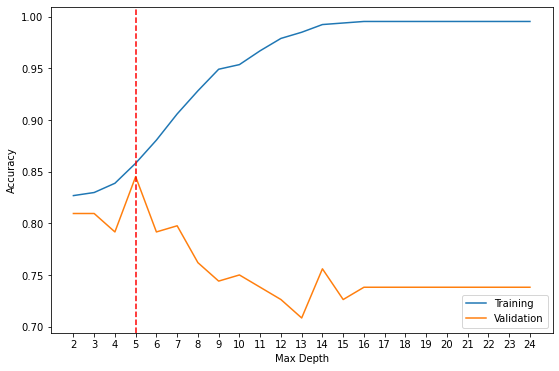

In [57]:
plt.figure(figsize=([9, 6]))
plt.plot(depth_range, dt_train_acc, label='Training')
plt.plot(depth_range, dt_valid_acc, label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depth_range)
plt.axvline(x=dt_opt_depth, ls='--', color='red') #added vertical line to show optimal tuning
plt.legend()
plt.show()

In [58]:
#predictions on new data set
pred_dt = tree.predict(X_test_final)
print(pred_dt)
print(len(pred_dt))

#number of occurrences of No(0) and Yes(1) in the prediction
unique, counts = np.unique(pred_dt, return_counts=True)
dict(zip(unique, counts))

[0 0 0 ... 0 0 0]
5000


{0: 4365, 1: 635}

**Random Forest**

This model produces the best validation results, and would likely be the one used for final predictions if only one were to be chosen.

In [59]:
rf_train_acc = []
rf_valid_acc = []

depth_range = range(2,25)

for d in depth_range:
    np.random.seed(1)
    temp_forest = RandomForestClassifier(n_estimators=100, max_depth=d)
    temp_forest.fit(X_train, y_train)
    rf_train_acc.append(temp_forest.score(X_train, y_train))
    rf_valid_acc.append(temp_forest.score(X_valid, y_valid))
    
rf_idx = np.argmax(rf_valid_acc)
rf_opt_depth = depth_range[rf_idx]

forest = RandomForestClassifier(max_depth=rf_opt_depth, random_state=1)
forest.fit(X_train, y_train)

print('Optimal value of max_depth:           ', rf_opt_depth)
print('Training Accuracy for Optimal Model:  ', round(forest.score(X_train, y_train),4))
print('Validation Accuracy for Optimal Model:', round(forest.score(X_valid, y_valid),4))

Optimal value of max_depth:            3
Training Accuracy for Optimal Model:   0.8104
Validation Accuracy for Optimal Model: 0.8512


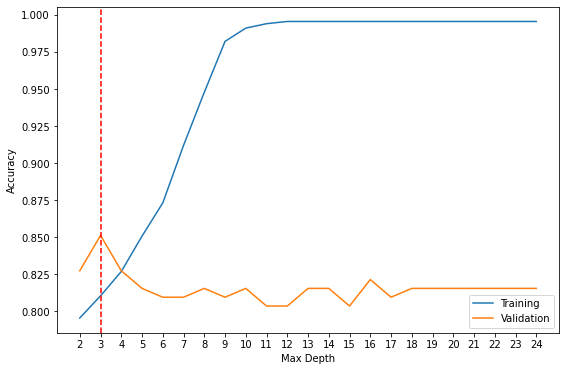

In [60]:
plt.figure(figsize=([9, 6]))
plt.plot(depth_range, rf_train_acc, label='Training')
plt.plot(depth_range, rf_valid_acc, label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depth_range)
plt.axvline(x=rf_opt_depth, ls='--', color='red') #added vertical line to show optimal tuning
plt.legend()
plt.show()

In [61]:
#predictions on new data set
pred_rf = forest.predict(X_test_final)
print(pred_rf)
print(len(pred_rf))

#number of occurrences of No(0) and Yes(1) in the prediction
unique, counts = np.unique(pred_rf, return_counts=True)
dict(zip(unique, counts))

[0 0 0 ... 0 0 0]
5000


{0: 4559, 1: 441}

Compiling a new dataframe with the predictions alongside the variables.

In [62]:
OutcomeDF = X_test_final.copy()
OutcomeDF['LeftUnionPred_LOG'] = pred_log
OutcomeDF['LeftUnionPred_DT'] = pred_dt
OutcomeDF['LeftUnionPred_RF'] = pred_rf
OutcomeDF['DS_ID'] = pd.Series(test['DS_ID'])

col_name='DS_ID'
first_col = OutcomeDF.pop(col_name)
OutcomeDF.insert(0, col_name, first_col)

#export dataframe as .csv
OutcomeDF.to_csv(r'C:\Users\dusti\Documents\Maryville\MachineLearning\Final_Outcome_Berry.csv', 
                 index=False, header=True)

OutcomeDF

,DS_ID,MonthsInUnion,MonthlyDues,TotalDues,Management,gender_Female,gender_Male,USAcitizen_No,USAcitizen_Yes,Married_No,...,DuesFrequency_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,LeftUnionPred_LOG,LeftUnionPred_DT,LeftUnionPred_RF
0,10000,-1.268931,-1.154574,-0.990430,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0
1,10001,0.070734,-0.258882,-0.169917,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0
2,10002,-1.228335,-0.358403,-0.956021,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0
3,10003,0.517289,-0.756488,-0.191533,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0
4,10004,-1.228335,0.205551,-0.936611,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,14995,-1.025355,0.338247,-0.759716,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,1,0
4996,14996,0.598481,0.305073,0.538547,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0
4997,14997,-1.228335,-0.656967,-0.962197,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0
4998,14998,1.207420,1.532503,2.107668,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0


## Final Thoughts

**Comparing your results, to that of a blind guess, explain why you think the results differed?**

The blind guess based on the percentage that had stayed in the union in the training dataset were fairly high.  I think the additional improvements based on a guess using that as a guide came from reducing the overall variables by removing the ones that were correlated.  This, along with standardization of the numerical features, allowed the models to mathematically find the best solutions to the problem at hand.

**Describe how you would improve your project if you had more time?**

With more time I would like to understand model optimization and combination.  I think that this would allow higher degrees of accuracy for the overall predictions.